# Slope graphs showing effect of E484


In [1]:
import pandas as pd

from plotnine import *

,display_name,mutant,mutation,variant,neutralization titer,one_dose,dose_color
0,subject B (day 26),E484P,E484P,E484 mutant,341.40,14,mean titer before\n2nd dose of Pfizer\nBNT162b...
1,subject B (day 113),E484P,E484P,E484 mutant,221.90,14,mean titer before\n2nd dose of Pfizer\nBNT162b...
2,subject C (day 32),E484P,E484P,E484 mutant,212.20,14,mean titer before\n2nd dose of Pfizer\nBNT162b...
3,subject C (day 104),E484P,E484P,E484 mutant,136.60,14,mean titer before\n2nd dose of Pfizer\nBNT162b...
4,subject I (day 26),E484Q,E484Q,E484 mutant,20.13,14,mean titer before\n2nd dose of Pfizer\nBNT162b...


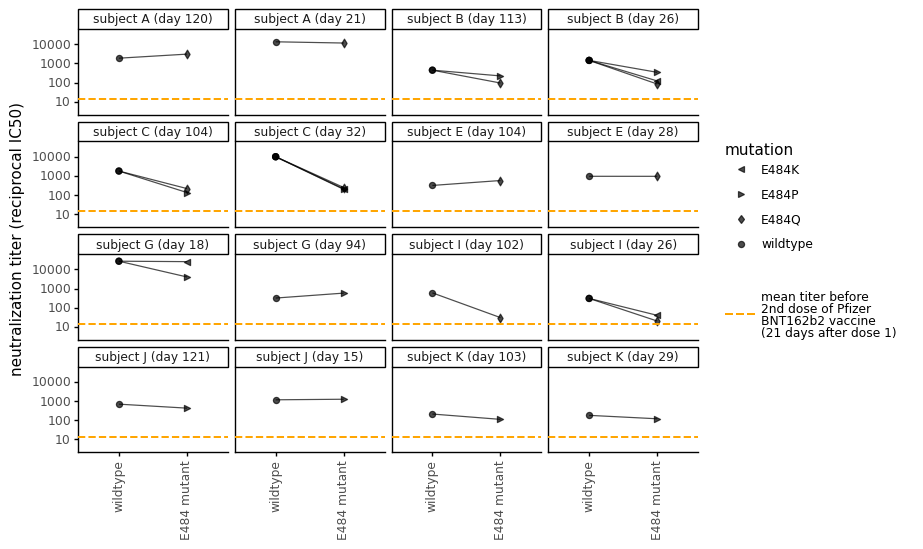

In [2]:
df = (pd.read_csv('results/mutant_neuts_results/mutants_foldchange_ic50.csv')
      .query('display_name.notnull()')
      .query('mutant.str.contains("^E484")')
      .assign(wildtype_NT50=lambda x: 1 /x['wildtype_ic50'])
      .melt(id_vars=['display_name', 'mutant'],
            value_vars=['NT50', 'wildtype_NT50'],
            value_name='neut_titer'
            )
      .assign(mutation=lambda x: x.apply(lambda r: 'wildtype' if r['variable'] == 'wildtype_NT50'
                                                    else r['mutant'],
                                        axis=1),
              variant=lambda x: x['mutation'].map(lambda s: 'wildtype' if s == 'wildtype' else
                                                            'E484 mutant'),
              neut_titer=lambda x: x.groupby(['display_name', 'mutation'])['neut_titer'].transform('mean')
              )
      .rename(columns={'neut_titer': 'neutralization titer'})
      [['display_name', 'mutant', 'mutation', 'variant', 'neutralization titer']]
      .assign(variant=lambda x: pd.Categorical(x['variant'], ['wildtype', 'E484 mutant'], ordered=True))
      )

# 14 is mean titer at 21 days for Pfizer BNT162b2 in 30 ug group at day 21 (immediately before second dose)
# https://www.nejm.org/doi/full/10.1056/NEJMoa2027906
df['one_dose'] = 14
df['dose_color'] = ('mean titer before\n'
                    '2nd dose of Pfizer\n'
                    'BNT162b2 vaccine\n'
                    '(21 days after dose 1)')

display(df.head())

p = (ggplot(df) +
     aes('variant', 'neutralization titer', group='mutant',
         shape='mutation') +
     geom_point(size=2, alpha=0.7) +
     geom_line(alpha=0.7) +
     facet_wrap('display_name') +
     scale_y_log10(name='neutralization titer (reciprocal IC50)',
                   expand=(0.1, 0),
                   breaks=[10, 100, 1000, 10000],
                   labels=['$10$', '$100$', '$1000$', '$10000$']
                   ) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(8, 5.5),
           legend_key_width=23,
           ) +
     xlab('') +
     expand_limits(y=5) +
     geom_hline(aes(yintercept='one_dose', linetype='dose_color'), color='orange', size=0.8) +
     scale_shape_manual(values=['<', '>', 'd', 'o']) +
     scale_linetype_manual(values=['dashed']) +
     labs(linetype='')
     )

p.save('E484_slope_graph.pdf', verbose=False)
_ = p.draw()